In [106]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import networkx as nx
from IPython.display import clear_output

In [107]:
def set_seed(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

seed = 1337
set_seed(seed)

In [108]:
import os
import sys

notebook_dir = os.getcwd()

root_dir = os.path.abspath(os.path.join(notebook_dir, "../../"))
sys.path.append(root_dir)

In [109]:
from dotenv import load_dotenv

load_dotenv()

from coral import DataSourceFactory
from core.models.datasource_type import DataSourceType
from core.models.protocol_type import ProtocolType
from service import EnvironmentSecretService

In [152]:
DEFAULT_DATASOUCE = DataSourceType.BYBIT
DEFAULT_SYMBOLS = ["APEUSDT"]
SLEEP_INTERVAL = 1
DOM = 10

In [153]:
datasource = DataSourceFactory(EnvironmentSecretService())
datasource.register_rest_exchange(DEFAULT_DATASOUCE)

ds = datasource.create(DEFAULT_DATASOUCE, ProtocolType.REST)

In [154]:
symbols = ds.fetch_future_symbols()
symbol = [symbol for symbol in symbols if symbol.name in DEFAULT_SYMBOLS]

In [8]:
def plot_order_book(bids, asks, highlight_best=True):
    bids_df = pd.DataFrame(bids, columns=['price', 'quantity'])
    asks_df = pd.DataFrame(asks, columns=['price', 'quantity'])

    bids_df = bids_df.sort_values(by='price', ascending=False)
    asks_df = asks_df.sort_values(by='price', ascending=True)

    bids_df['cum_quantity'] = bids_df['quantity'].cumsum()
    asks_df['cum_quantity'] = asks_df['quantity'].cumsum()

    clear_output(wait=True)

    sns.set_style("whitegrid")

    plt.figure(figsize=(14, 9))

    sns.lineplot(x=bids_df['price'], y=bids_df['cum_quantity'], label='Bids', color='green', linewidth=2)
    sns.lineplot(x=asks_df['price'], y=asks_df['cum_quantity'], label='Asks', color='red', linewidth=2)

    bid_imbalance = bids_df['cum_quantity'].max() - asks_df['cum_quantity'].mean()
    ask_imbalance = asks_df['cum_quantity'].max() - bids_df['cum_quantity'].mean()
    imbalance_threshold = (bid_imbalance + ask_imbalance) / 2

    plt.axhline(imbalance_threshold, color='orange', linestyle='--', label=f'Imbalance Threshold: {imbalance_threshold:.2f}')

    plt.fill_between(bids_df['price'], bids_df['cum_quantity'], color='green', alpha=0.3, step='mid')
    plt.fill_between(asks_df['price'], asks_df['cum_quantity'], color='red', alpha=0.3, step='mid')

    if highlight_best:
        best_bid = bids_df['price'].iloc[0]
        best_ask = asks_df['price'].iloc[0]

        plt.axvline(best_bid, color='green', linestyle='--', label=f'Best Bid: {best_bid:.2f}', linewidth=1.5)
        plt.axvline(best_ask, color='red', linestyle='--', label=f'Best Ask: {best_ask:.2f}', linewidth=1.5)

        mid_price = (best_bid + best_ask) / 2
        plt.axvline(mid_price, color='blue', linestyle=':', label=f'Mid Price: {mid_price:.2f}', linewidth=1.5)

    vwap_bid = (bids_df['price'] * bids_df['quantity']).sum() / bids_df['quantity'].sum()
    vwap_ask = (asks_df['price'] * asks_df['quantity']).sum() / asks_df['quantity'].sum()

    plt.axvline(vwap_bid, color='darkgreen', linestyle=':', label=f'VWAP Bid: {vwap_bid:.2f}', linewidth=1.2)
    plt.axvline(vwap_ask, color='darkred', linestyle=':', label=f'VWAP Ask: {vwap_ask:.2f}', linewidth=1.2)

    plt.xlabel('Price', fontsize=12)
    plt.ylabel('Cumulative Quantity', fontsize=12)
    plt.title('Order Book Depth Chart', fontsize=14)

    plt.legend()

    plt.show()

In [9]:
def plot_order_book(bids, asks):
    bids_df = pd.DataFrame(bids, columns=['price', 'quantity'])
    asks_df = pd.DataFrame(asks, columns=['price', 'quantity'])

    bids_df = bids_df.sort_values(by='price', ascending=False)
    asks_df = asks_df.sort_values(by='price', ascending=True)

    bids_df['cum_quantity'] = bids_df['quantity'].cumsum()
    asks_df['cum_quantity'] = asks_df['quantity'].cumsum()

    best_bid = bids_df['price'].iloc[0]
    best_ask = asks_df['price'].iloc[0]


    mid_price = (best_bid + best_ask) / 2

    spread = best_ask - best_bid
    mid_spread = spread / 2

    bids_df['relative_price'] = bids_df['price'] - best_bid - mid_spread
    asks_df['relative_price'] = asks_df['price'] - best_ask + mid_spread

    clear_output(wait=True)

    sns.set_style("whitegrid")

    plt.figure(figsize=(14, 9))

    plt.bar(bids_df['relative_price'], -bids_df['cum_quantity'], color='green', label='Bids', width=spread/2, alpha=0.9)
    plt.bar(asks_df['relative_price'], asks_df['cum_quantity'], color='red', label='Asks', width=spread/2, alpha=0.9)

    plt.axvline(-mid_spread, color='green', linestyle='--', label=f'Best Bid: {best_bid:.2f}', linewidth=1.5)
    plt.axvline(0, color='blue', linestyle=':', label=f'Mid Price: {mid_price:.2f}', linewidth=1.5)
    plt.axvline(mid_spread, color='red', linestyle='--', label=f'Best Ask: {best_ask:.2f}', linewidth=1.5)

    plt.xlabel('Price Relative to Best Bid (Spread Divider)', fontsize=12)
    plt.ylabel('Cumulative Quantity (Depth)', fontsize=12)
    plt.title('Order Book Depth Bar Chart', fontsize=14)

    plt.legend()
    plt.show()

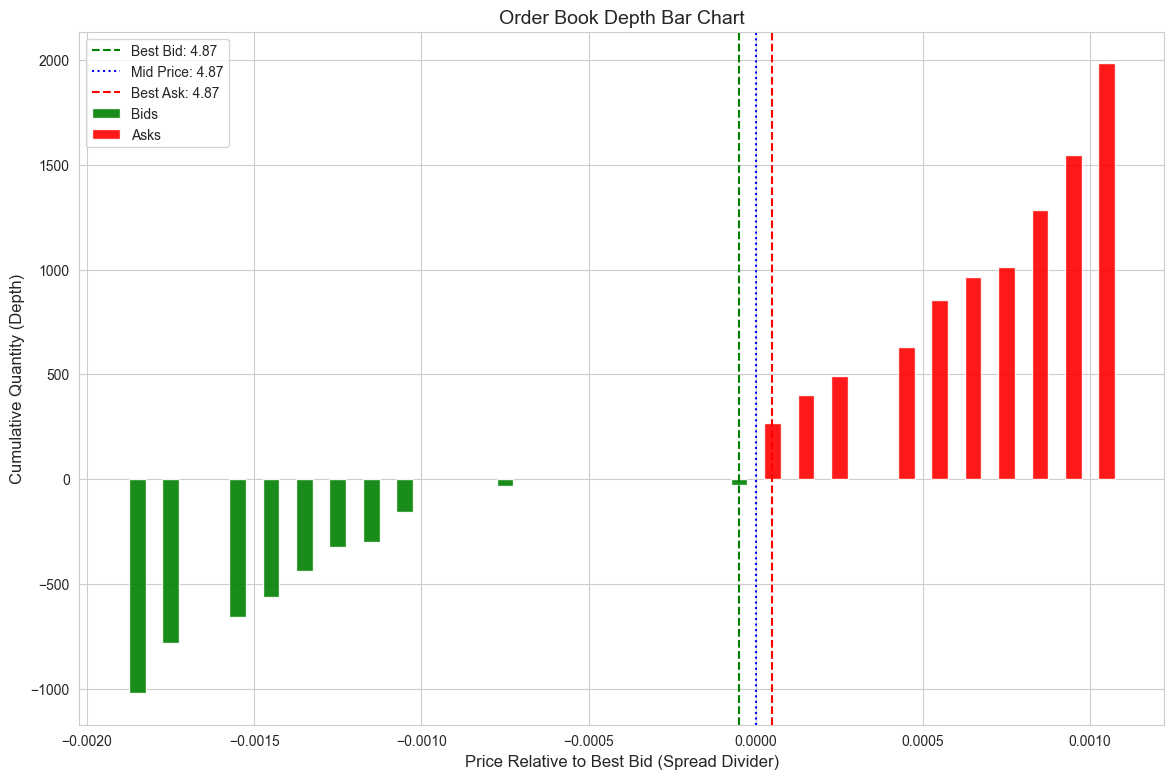

KeyboardInterrupt: 

In [10]:
while True:
    bids, asks, timestamp = ds.fetch_order_book(symbol[0], DOM)

    plot_order_book(np.array(bids), np.array(asks))

    time.sleep(SLEEP_INTERVAL)

In [34]:
def calculate_order_slices(symbol, total_size):
    x_min = symbol.min_position_size
    alpha = np.random.uniform(1.3, 1.5)

    while True:
        u = np.random.rand()

        order_size = x_min * (1 - u) ** (-1 / (alpha - 1))

        order_size = min(order_size, total_size)

        yield order_size

In [35]:
def plot_order_sizes(order_sizes):
    sns.set_style(style="whitegrid")

    plt.figure(figsize=(10, 6))
    sns.histplot(order_sizes, bins=30, kde=False, color='blue', edgecolor='black', stat='density', alpha=0.6)
    plt.title('Distribution of Sampled Order Sizes')
    plt.xlabel('Order Size')
    plt.ylabel('Density')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

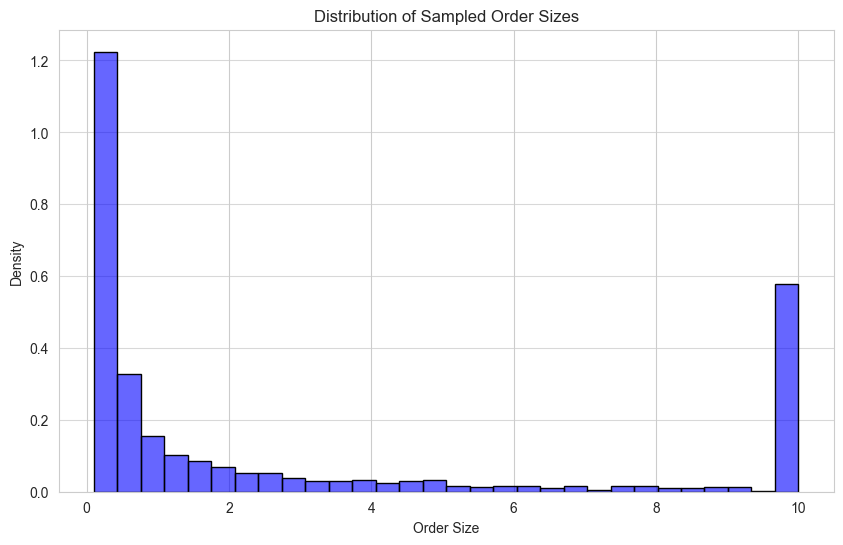

In [36]:
total_size = 10
num_samples = 1000

order_generator = calculate_order_slices(symbol=symbol[0], total_size=total_size)
order_sizes = [next(order_generator) for _ in range(num_samples)]

plot_order_sizes(order_sizes)


In [155]:
SLEEP_INTERVAL = 8
ONE_HOUR = 3600
MULTI = 8
ORDER_BOOK_FILE = f'order_book_{symbol[0].name}_8h.csv'

In [157]:
columns = ['timestamp'] + [item for i in range(1, DOM + 1) for item in [
    f'Ask {i} Price', 
    f'Ask {i} Size', 
    f'Bid {i} Price', 
    f'Bid {i} Size'
]]

df = pd.DataFrame(columns=columns)

start_time = time.time()
end_time = ONE_HOUR * MULTI

while True:
    bids, asks, timestamp = ds.fetch_order_book(symbol[0], DOM)

    row = [timestamp]

    for i in range(DOM):
        row.extend([asks[i][0], asks[i][1], bids[i][0], bids[i][1]])

    df.loc[len(df)] = row

    time.sleep(SLEEP_INTERVAL)
    
    if time.time() - start_time > end_time:
        break

df.to_csv(ORDER_BOOK_FILE, index=False)

df.head()

Error: bybit GET https://api.bybit.com/v5/market/orderbook?symbol=NEARUSDT&category=linear&limit=10. Retrying...
Error: bybit GET https://api.bybit.com/v5/market/orderbook?symbol=NEARUSDT&category=linear&limit=10. Retrying...
Error: bybit GET https://api.bybit.com/v5/market/orderbook?symbol=NEARUSDT&category=linear&limit=10. Retrying...
Error: bybit GET https://api.bybit.com/v5/market/orderbook?symbol=NEARUSDT&category=linear&limit=10. Retrying...
Error: bybit GET https://api.bybit.com/v5/market/orderbook?symbol=NEARUSDT&category=linear&limit=10. Retrying...


,timestamp,Ask 1 Price,Ask 1 Size,Bid 1 Price,Bid 1 Size,Ask 2 Price,Ask 2 Size,Bid 2 Price,Bid 2 Size,Ask 3 Price,...,Bid 8 Price,Bid 8 Size,Ask 9 Price,Ask 9 Size,Bid 9 Price,Bid 9 Size,Ask 10 Price,Ask 10 Size,Bid 10 Price,Bid 10 Size
0,1.730056e+12,4.280,2513.2,4.279,4218.5,4.281,7551.7,4.278,7538.5,4.282,...,4.272,8224.3,4.288,3854.1,4.271,19003.1,4.289,9387.8,4.270,33433.3
1,1.730056e+12,4.280,1149.8,4.279,4288.9,4.281,5404.6,4.278,7540.2,4.282,...,4.272,11618.2,4.288,21779.6,4.271,15728.4,4.289,9387.8,4.270,33317.5
2,1.730056e+12,4.281,2115.3,4.280,4729.0,4.282,9263.3,4.279,8122.9,4.283,...,4.273,21736.1,4.289,8899.8,4.272,25333.1,4.290,16336.0,4.271,10805.6
3,1.730056e+12,4.282,88.2,4.281,6457.2,4.283,5208.9,4.280,9806.8,4.284,...,4.274,7025.2,4.290,16246.7,4.273,15967.1,4.291,12401.1,4.272,36558.6
4,1.730056e+12,4.282,2138.9,4.281,3458.3,4.283,5205.0,4.280,9738.6,4.284,...,4.274,7025.2,4.290,16470.0,4.273,16259.1,4.291,12401.1,4.272,36171.9


In [158]:
def fe(df, k=8):
    df = df.copy()
   
    df['P'] = (df['Ask 1 Price'] + df['Bid 1 Price']) / 2
    df['PS'] = (df['Ask 1 Price'] - df['Bid 1 Price'])
    
    df['P+'] = df['P'].rolling(window=k).mean()
    df['P+'] = df['P+'].fillna(df['P'])

    df['d'] = (df['P+'] - df['P']) / df['P']
    
    df['R'] = (df['P'].shift(-1) - df['P']) / df['P']
    df['R'] = df['R'].fillna(0)
    
    df['D_B'] = df[[f'Bid {i} Size' for i in range(1, DOM + 1)]].sum(axis=1)
    df['D_A'] = df[[f'Ask {i} Size' for i in range(1, DOM + 1)]].sum(axis=1)

    df['DI'] = (df['D_B'] - df['D_A']) / (df['D_B'] + df['D_A'])

    df['BI'] = ((df['Bid 1 Price'] - df[f'Bid {DOM} Price']) - (df[f'Ask {DOM} Price'] - df['Ask 1 Price'])) / ((df['Bid 1 Price'] - df[f'Bid {DOM} Price']) + (df[f'Ask {DOM} Price'] - df['Ask 1 Price']))

    df['VI'] = (df['Bid 1 Size'] - df['Ask 1 Size']) / (df['Bid 1 Size'] + df['Ask 1 Size'])

    df['M'] = (df['Bid 1 Size'] / (df['Bid 1 Size'] + df['Ask 1 Size'])) * df['Ask 1 Price'] + (df['Ask 1 Size'] / (df['Bid 1 Size'] + df['Ask 1 Size'])) * df['Bid 1 Price']

    return df[['timestamp', 'P', 'PS', 'R', 'DI', 'BI', 'VI', 'M', 'd']]

df = pd.read_csv(ORDER_BOOK_FILE)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

df_fe = fe(df)

df_fe.head()

,timestamp,P,PS,R,DI,BI,VI,M,d
0,2024-10-27 19:09:18.747,4.2795,0.001,0.000000,0.099049,4.934325e-14,0.253324,4.279627,0.0
1,2024-10-27 19:09:26.747,4.2795,0.001,0.000234,0.109309,4.934325e-14,0.577178,4.279789,0.0
2,2024-10-27 19:09:35.847,4.2805,0.001,0.000234,0.021080,0.000000e+00,0.381880,4.280691,0.0
3,2024-10-27 19:09:44.146,4.2815,0.001,0.000000,0.054851,-4.934325e-14,0.973050,4.281987,0.0
4,2024-10-27 19:09:52.547,4.2815,0.001,0.000000,0.037161,-4.934325e-14,0.235725,4.281618,0.0


In [188]:
def label_data(df, alpha):
    df = df.copy()
    df['y'] = np.where(df['d'] > alpha, 1, np.where(df['d'] < -alpha, -1, 0))
    return df

def plot_label_distribution(df):
    label_counts = df['y'].value_counts()
    
    plt.figure(figsize=(6, 3))
    sns.barplot(x=label_counts.index, y=label_counts.values, hue=label_counts.index, palette="viridis", dodge=False)
    
    plt.title('Class Distribution of Labels')
    plt.xlabel('Class Labels')
    plt.ylabel('Frequency')
    plt.title("Labels")
    plt.legend(loc="upper right")
    plt.show()

In [160]:
import numpy as np
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

best_alpha = None
best_imbalance_ratio = float('inf')
BIG_NUM = 1e10

def calculate_imbalance_ratio(label_counts):
    positive_count = label_counts.get(1, 0)
    negative_count = label_counts.get(-1, 0)
    neutral_count = label_counts.get(0, 0)
    
    total_count = positive_count + negative_count + neutral_count
    
    if total_count == 0:
        return BIG_NUM
    
    weight_pos = positive_count / total_count
    weight_neg = negative_count / total_count
    weight_neutral = neutral_count / total_count
    
    neutral_penalty = weight_neutral ** 2
    
    if positive_count == 0 or negative_count == 0:
        balance_penalty = BIG_NUM
    else:
        balance_penalty = (abs(weight_pos - weight_neg)) ** 2
    
    return min(balance_penalty + 0.15 * neutral_penalty, BIG_NUM)

search_space = [Real(1e-6, 1e-2, "log-uniform", name="alpha")]

@use_named_args(search_space)
def optimize_alpha(alpha):
    df_l = label_data(df_fe, alpha)
    label_counts = df_l['y'].value_counts()
    imbalance_ratio = calculate_imbalance_ratio(label_counts)
    
    if np.isinf(imbalance_ratio) or np.isnan(imbalance_ratio):
        imbalance_ratio = BIG_NUM

    return imbalance_ratio

result = gp_minimize(
    func=optimize_alpha,
    dimensions=search_space,
    n_calls=30,
    n_random_starts=5,
    acq_func="EI",
    random_state=seed
)

best_alpha = result.x[0]
best_imbalance_ratio = result.fun

print(f"Best alpha: {best_alpha}")
print(f"Best imbalance ratio: {best_imbalance_ratio}")

/Users/siarheimelnik/Projects/quant-prod/.venv/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1.002879742349066e-06] before, using random point [0.002616982679369838]
  warnings.warn(


Best alpha: 7.085175249502597e-06
Best imbalance ratio: 0.002758594782519579


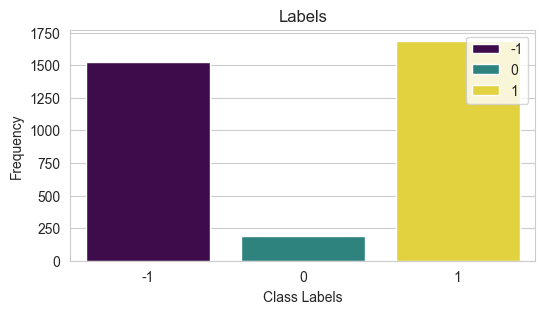

In [189]:
import seaborn as sns
import matplotlib.pyplot as plt

df_l = label_data(df_fe, best_alpha)

plot_label_distribution(df_l)

In [194]:
k = 10
EPS = np.finfo(float).eps

def normalize(X, y, features):
    X_normalized = X.copy()

    for col in features:
        rolling_mean = X[col].rolling(window=k).mean()
        rolling_std = X[col].rolling(window=k).std()
        X_normalized[col] = (X[col] - rolling_mean) / (rolling_std + EPS)

    X_normalized = X_normalized.dropna()
    y = y.loc[X_normalized.index]

    return X_normalized, y

In [195]:
from sklearn.calibration import label_binarize
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

def perform_kfold_cv(model, X, y, k_folds=5):
    kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=seed)
    predictions = np.zeros(y.shape)
    true_labels = np.zeros(y.shape)

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        fold_predictions = model.predict(X_test)

        predictions[test_index] = fold_predictions
        true_labels[test_index] = y_test

    return predictions, true_labels

def calculate_metrics(y_true, predictions):
    accuracy = accuracy_score(y_true, predictions)
    precision = precision_score(y_true, predictions, average='weighted', zero_division=1)
    recall = recall_score(y_true, predictions, average='weighted', zero_division=1)
    f1 = f1_score(y_true, predictions, average='weighted', zero_division=1)

    return accuracy, precision, recall, f1

def plot_regime(df, model_name):
    plt.figure(figsize=(16, 8))

    plt.plot(df['timestamp'], df['P'], color='gray', alpha=0.5, label='Feature P')

    plt.fill_between(df['timestamp'], df['P'], where=(df['regime'] == 1), 
                    color='green', alpha=0.3, label='Long')
    plt.fill_between(df['timestamp'], df['P'], where=(df['regime'] == -1), 
                    color='red', alpha=0.3, label='Short')
    
    plt.fill_between(df['timestamp'], df['P'], where=(df['regime'] == 0), 
                    color='blue', alpha=0.3, label='Range')

    plt.title(f'({model_name}) P and Regime')
    plt.xlabel('TS')
    plt.ylabel('P')
    plt.legend()
    plt.grid()

    plt.show()

def plot_roc_auc(model, X, y, k_folds=5):
    kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=seed)
    roc_auc_scores = []
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        fold_probs = model.predict_proba(X_test)

        y_test_bin = label_binarize(y_test, classes=np.unique(y))
        roc_auc = roc_auc_score(y_test_bin, fold_probs, average='macro', multi_class='ovr')
            
        for i in range(y_test_bin.shape[1]):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], fold_probs[:, i])
            tprs.append(np.interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0

        roc_auc_scores.append(roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(roc_auc_scores)

    plt.figure(figsize=(8, 5))
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'ROC Curve (AUC = {mean_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

In [196]:
k_folds = 5

features = ['P', 'PS', 'R', 'DI', 'BI', 'VI', 'M']

X = df_l[features]
y = df_l['y']

model = LogisticRegression(solver='liblinear', random_state=seed)
X_normalized, y = normalize(X, y, features)

predictions, true_labels = perform_kfold_cv(model, X_normalized, y, k_folds)
accuracy, precision, recall, f1 = calculate_metrics(true_labels, predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9032
Precision: 0.9084
Recall: 0.9032
F1 Score: 0.8786


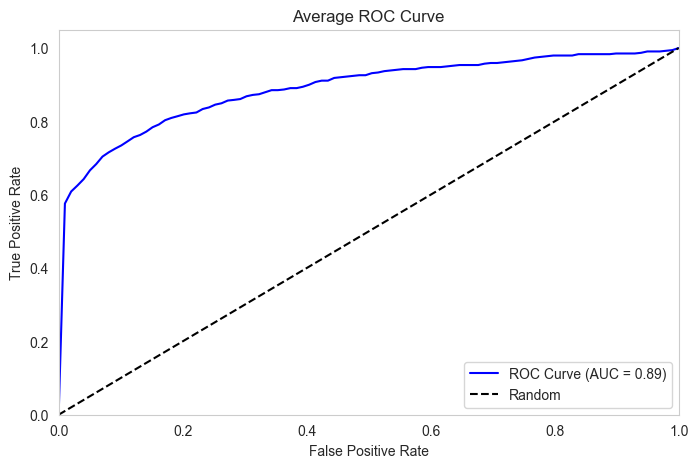

In [197]:
plot_roc_auc(model, X_normalized, y, k_folds)

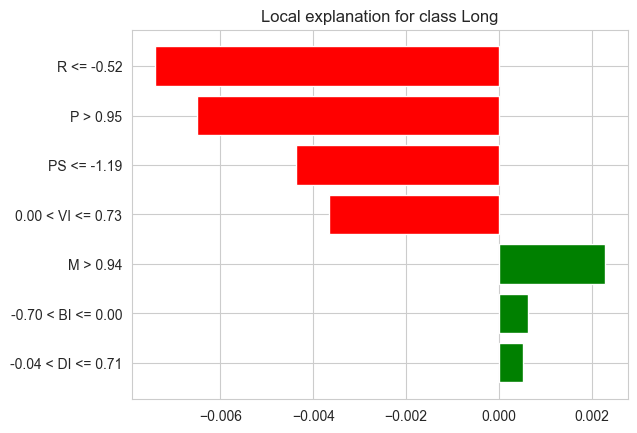

In [198]:
from lime.lime_tabular import LimeTabularExplainer

lime_explainer = LimeTabularExplainer(X_normalized.values, mode="classification", 
                                      feature_names=features, class_names=['Short', 'Long', 'Range'], 
                                      discretize_continuous=True)

def lime_predict_proba(data):
    data_df = pd.DataFrame(data, columns=features)
    return model.predict_proba(data_df)

random_index = np.random.randint(0, len(X_normalized))
exp = lime_explainer.explain_instance(X_normalized.iloc[random_index].values, lime_predict_proba, num_features=len(features))

exp.show_in_notebook(show_table=True)
exp.as_pyplot_figure()

plt.show()

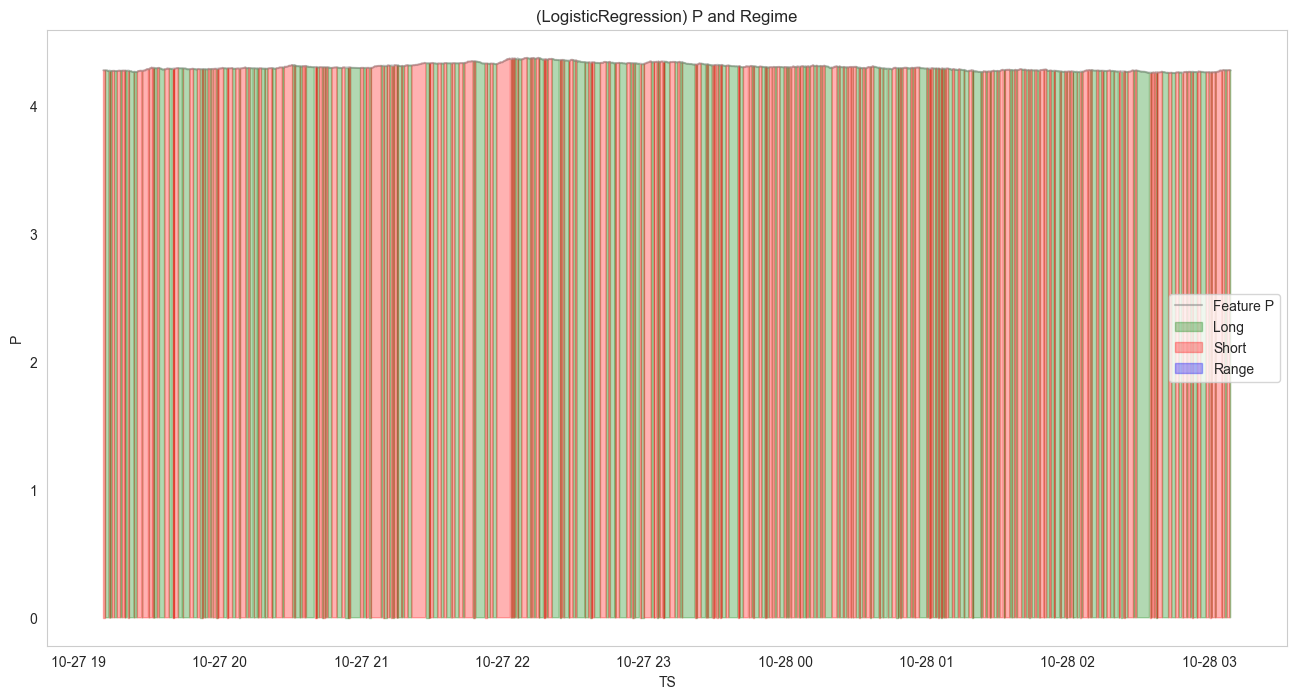

In [199]:
dpred = df_l.loc[X_normalized.index].copy()
dpred['regime'] = predictions

plot_regime(dpred, model.__class__.__name__)

In [114]:
def hawkes_intensity(t, mu, alpha, beta, event_times):
    intensity = mu
    for t_k in event_times[event_times < t]:
        intensity += alpha * np.exp(-beta * (t - t_k))
    return intensity

In [115]:
time = 100
mu = 0.01
alpha = 0.5
beta = 1.0
threshold = 0.02

event_times = df_fe[df_fe['R'].abs() > threshold]['timestamp'].values

G = nx.DiGraph()

for index, row in df_fe.iterrows():
    G.add_node(index, timestamp=row['timestamp'], P=row['P'], R=row['R'], DI=row['DI'], BI=row['BI'])

for i in range(len(df_fe) - 1):
    row_curr = df_fe.iloc[i]
    row_next = df_fe.iloc[i + 1]

    base_weight = np.abs(row_next['R'] - row_curr['R']) + np.abs(row_next['BI'] - row_curr['BI'])
    
    time_diff = (row_next['timestamp'] - row_curr['timestamp']).total_seconds()
    
    hawkes_adjustment = hawkes_intensity(row_next['timestamp'], mu, alpha, beta, event_times)
    
    final_weight = base_weight * hawkes_adjustment / (1 + time_diff)
    
    G.add_edge(row_curr['timestamp'], row_next['timestamp'], weight=final_weight)

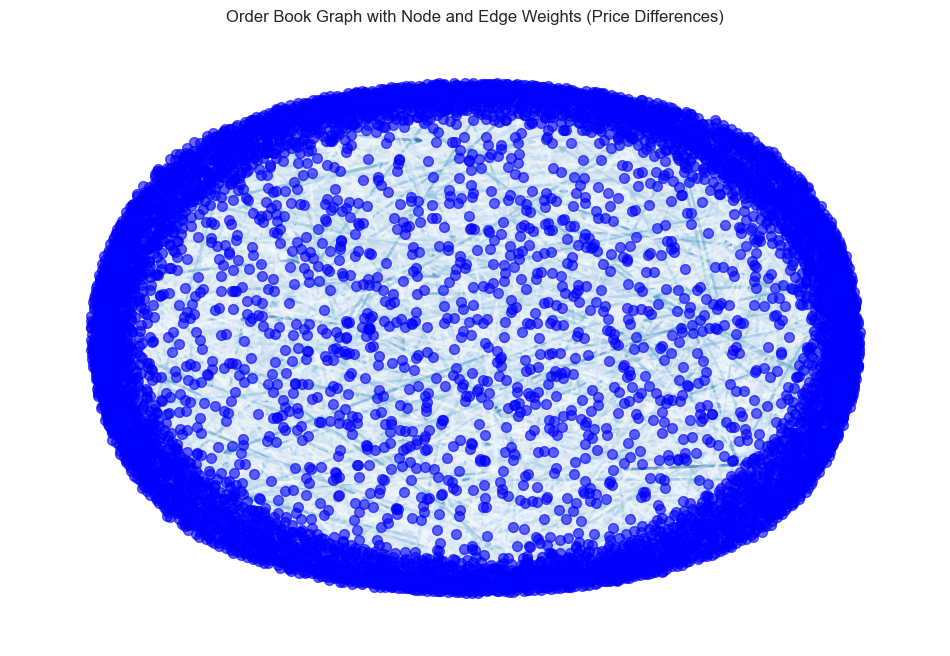

In [117]:
pos = nx.spring_layout(G)

plt.figure(figsize=(12, 8))
sns.set_style('whitegrid')

nx.draw_networkx_nodes(G, pos, node_size=50, node_color='blue', alpha=0.6)

edges = G.edges(data=True)
weights = [edge[2]['weight'] for edge in edges]

nx.draw_networkx_edges(G, pos, edge_color=weights, edge_cmap=plt.cm.Blues, width=2, alpha=0.5)

plt.axis('off')
plt.title("Order Book Graph with Node and Edge Weights (Price Differences)")
plt.show()